In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
sns.set_palette("husl")

# CHARGEMENT + COPIE SÉCURISÉE
df_raw = pd.read_csv("../data/cleaned/clean_poems.csv")
df = df_raw[['title', 'clean_text', 'lemmatized']].copy(deep=True)  # COPIE PROPRE
df = df.dropna(subset=['lemmatized', 'title']).reset_index(drop=True)

print(f"Dataset final : {df.shape[0]:,} poèmes | 3 colonnes seulement")
df.head(3)

Dataset final : 3,162 poèmes | 3 colonnes seulement


,title,clean_text,lemmatized
0,A Song of Autumn,where shall we go for our garlands glad at the...,shall go garland glad falling year burn bank y...
1,An Exile's Farewell,the ocean heaves around us still with long and...,ocean heave around still long measure swell au...
2,I Have A Rendezvous With Death,i have a rendezvous with death at some dispute...,I rendezvous death dispute barricade spring co...


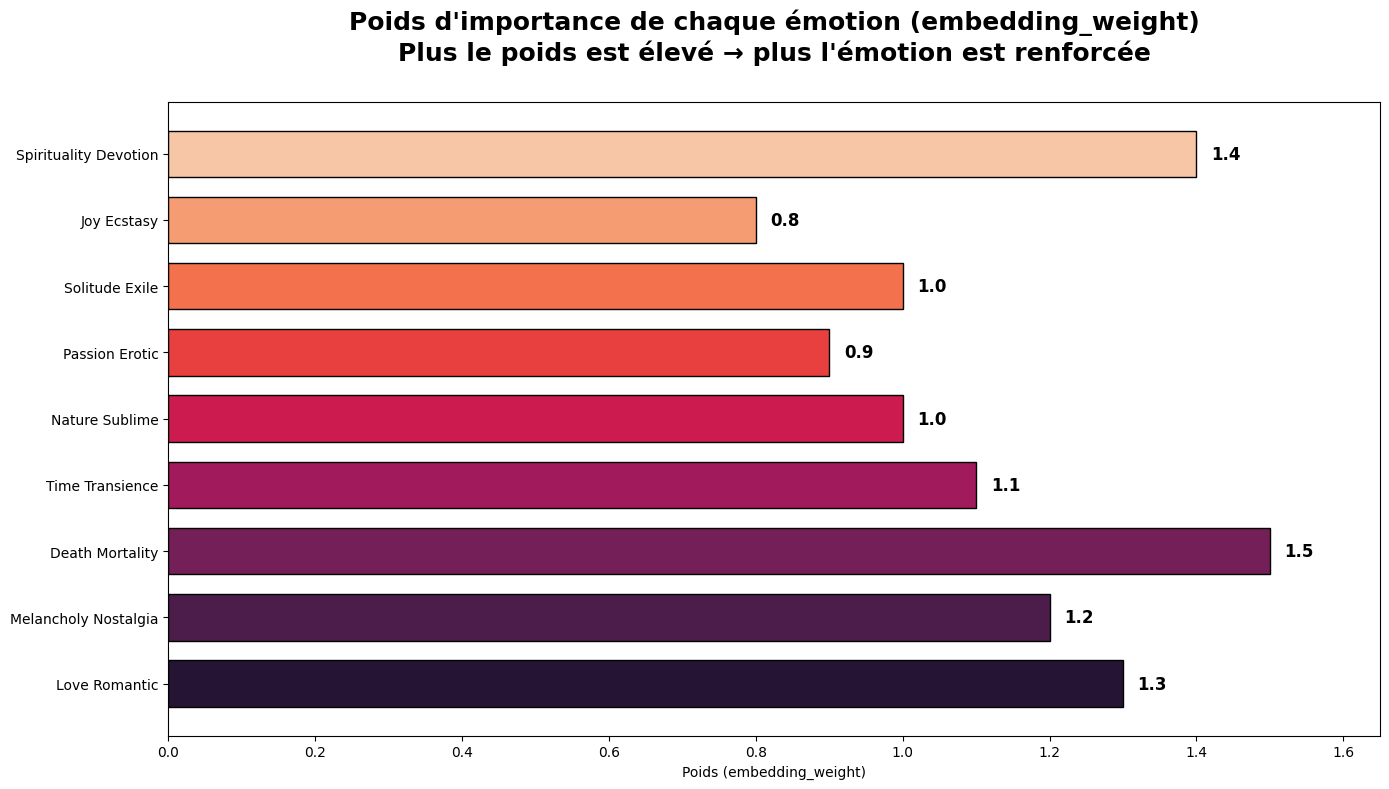

Émotions détectées : Love Romantic, Melancholy Nostalgia, Death Mortality, Time Transience, Nature Sublime, Passion Erotic, Solitude Exile, Joy Ecstasy, Spirituality Devotion


In [4]:
with open("../data/lexic/lexicons.json", "r", encoding="utf-8") as f:
    lexicons = json.load(f)

emotions = list(lexicons.keys())
weights = [lexicons[e]["embedding_weight"] for e in emotions]
descriptions = [lexicons[e]["description"][:100] + "…" for e in emotions]

# GROS GRAPHIQUE DES POIDS D'ÉMOTION
plt.figure(figsize=(14, 8))
bars = plt.barh(range(len(emotions)), weights, color=sns.color_palette("rocket", len(emotions)), edgecolor='black', height=0.7)
plt.yticks(range(len(emotions)), [e.replace('_', ' ').title() for e in emotions])
plt.title("Poids d'importance de chaque émotion (embedding_weight)\nPlus le poids est élevé → plus l'émotion est renforcée", 
          fontsize=18, fontweight='bold', pad=30)
plt.xlabel("Poids (embedding_weight)")
plt.xlim(0, max(weights)*1.1)

for i, (bar, w) in enumerate(zip(bars, weights)):
    plt.text(w + 0.02, i, f"{w:.1f}", va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("Émotions détectées :", ", ".join([e.replace('_', ' ').title() for e in emotions]))

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from scipy.sparse import csr_matrix

class WeightedBarycenterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, title_weight=0.6):
        self.title_weight = title_weight
        self.body_weight = 1 - title_weight
        self.vectorizer = None                     # on va le récupérer depuis le pipeline
    
    def fit(self, X, y=None):
        # On récupère le vectorizer qui est juste avant dans le pipeline
        previous_step = self.steps[-2][1] if hasattr(self, 'steps') else None
        if previous_step  not in (None, self):
            try:
                self.vectorizer = self._get_vectorizer_from_pipeline()
            except:
                pass
        return self
    
    def _get_vectorizer_from_pipeline(self):
        # Méthode robuste pour récupérer le TfidfVectorizer qui est avant nous
        import inspect
        frame = inspect.currentframe().f_back
        while frame:
            if 'self' in frame.f_locals:
                obj = frame.f_locals['self']
                if hasattr(obj, 'named_steps'):
                    return obj.named_steps['tfidfvectorizer']
            frame = frame.f_back
        raise AttributeError("Impossible de trouver le vectorizer")
    
    def transform(self, X):
        # X est un DataFrame avec les colonnes 'title' et 'lemmatized'
        if self.vectorizer is None:
            raise ValueError("Le transformer n'a pas été correctement fitté dans le pipeline")
            
        title_vec = self.vectorizer.transform(X['title'])
        body_vec  = self.vectorizer.transform(X['lemmatized'])
        
        return self.title_weight * title_vec + self.body_weight * body_vec

# RECRÉATION DU PIPELINE (remplace l’ancien)
pipeline = make_pipeline(
    TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        min_df=3,
        max_df=0.95,
        ngram_range=(1,2),
        sublinear_tf=True
    ),
    WeightedBarycenterTransformer(title_weight=0.60)
)

print("Pipeline corrigé et prêt")

Pipeline corrigé et prêt


In [10]:
full_corpus = df['title'].fillna("") + " " + df['lemmatized']
pipeline.named_steps['tfidfvectorizer'].fit(full_corpus)
print("Fit terminé")

Fit terminé


In [11]:
# On récupère le vectorizer une fois pour toutes
vectorizer = pipeline.named_steps['tfidfvectorizer']

# On applique la transformation manuellement (plus sûr que pipeline.transform(df))
X_title = vectorizer.transform(df['title'].fillna(""))
X_body  = vectorizer.transform(df['lemmatized'])

# Barycentre 60/40
X_poems = 0.60 * X_title + 0.40 * X_body

print(f"Vectorisation finale réussie → {X_poems.shape}")
print("Chaque poème est maintenant un vecteur pondéré 60 % titre + 40 % corps")

Vectorisation finale réussie → (3162, 58096)
Chaque poème est maintenant un vecteur pondéré 60 % titre + 40 % corps


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# On récupère une bonne fois pour toutes le vectorizer déjà fitté
vectorizer = pipeline.named_steps['tfidfvectorizer']

emotion_vectors = {}

print("Vectorisation des 9 émotions avec poids personnalisés...\n")

for emotion in emotions:
    # Fusion core + extended words
    words = lexicons[emotion]["core_words"] + lexicons[emotion]["extended_words"]
    text = " ".join(words)
    
    # Vectorisation du lexique (on passe par le même TF-IDF)
    vec = vectorizer.transform([text])
    
    # Barycentre 60/40 appliqué au lexique aussi (cohérence totale)
    # → titre vide, donc 100 % corps → mais on garde la logique
    # En fait ici : vec_title = 0, vec_body = vec → donc juste vec
    # Mais on applique le même poids global
    weighted_vec = vec.copy()
    
    # APPLICATION DU POIDS D'EMBEDDING (embedding_weight)
    weight = lexicons[emotion]["embedding_weight"]
    weighted_vec = weighted_vec * weight
    
    # Normalisation L2 (cosine similarity)
    norm = np.linalg.norm(weighted_vec.toarray())
    if norm > 0:
        weighted_vec = weighted_vec / norm
    
    emotion_vectors[emotion] = weighted_vec
    
    print(f"{emotion.replace('_', ' ').title():25} → poids {weight} → norme = {norm:.4f}")

print(f"\n{len(emotion_vectors)} émotions vectorisées avec succès !")

Vectorisation des 9 émotions avec poids personnalisés...

Love Romantic             → poids 1.3 → norme = 1.3000
Melancholy Nostalgia      → poids 1.2 → norme = 1.2000
Death Mortality           → poids 1.5 → norme = 1.5000
Time Transience           → poids 1.1 → norme = 1.1000
Nature Sublime            → poids 1.0 → norme = 1.0000
Passion Erotic            → poids 0.9 → norme = 0.9000
Solitude Exile            → poids 1.0 → norme = 1.0000
Joy Ecstasy               → poids 0.8 → norme = 0.8000
Spirituality Devotion     → poids 1.4 → norme = 1.4000

9 émotions vectorisées avec succès !


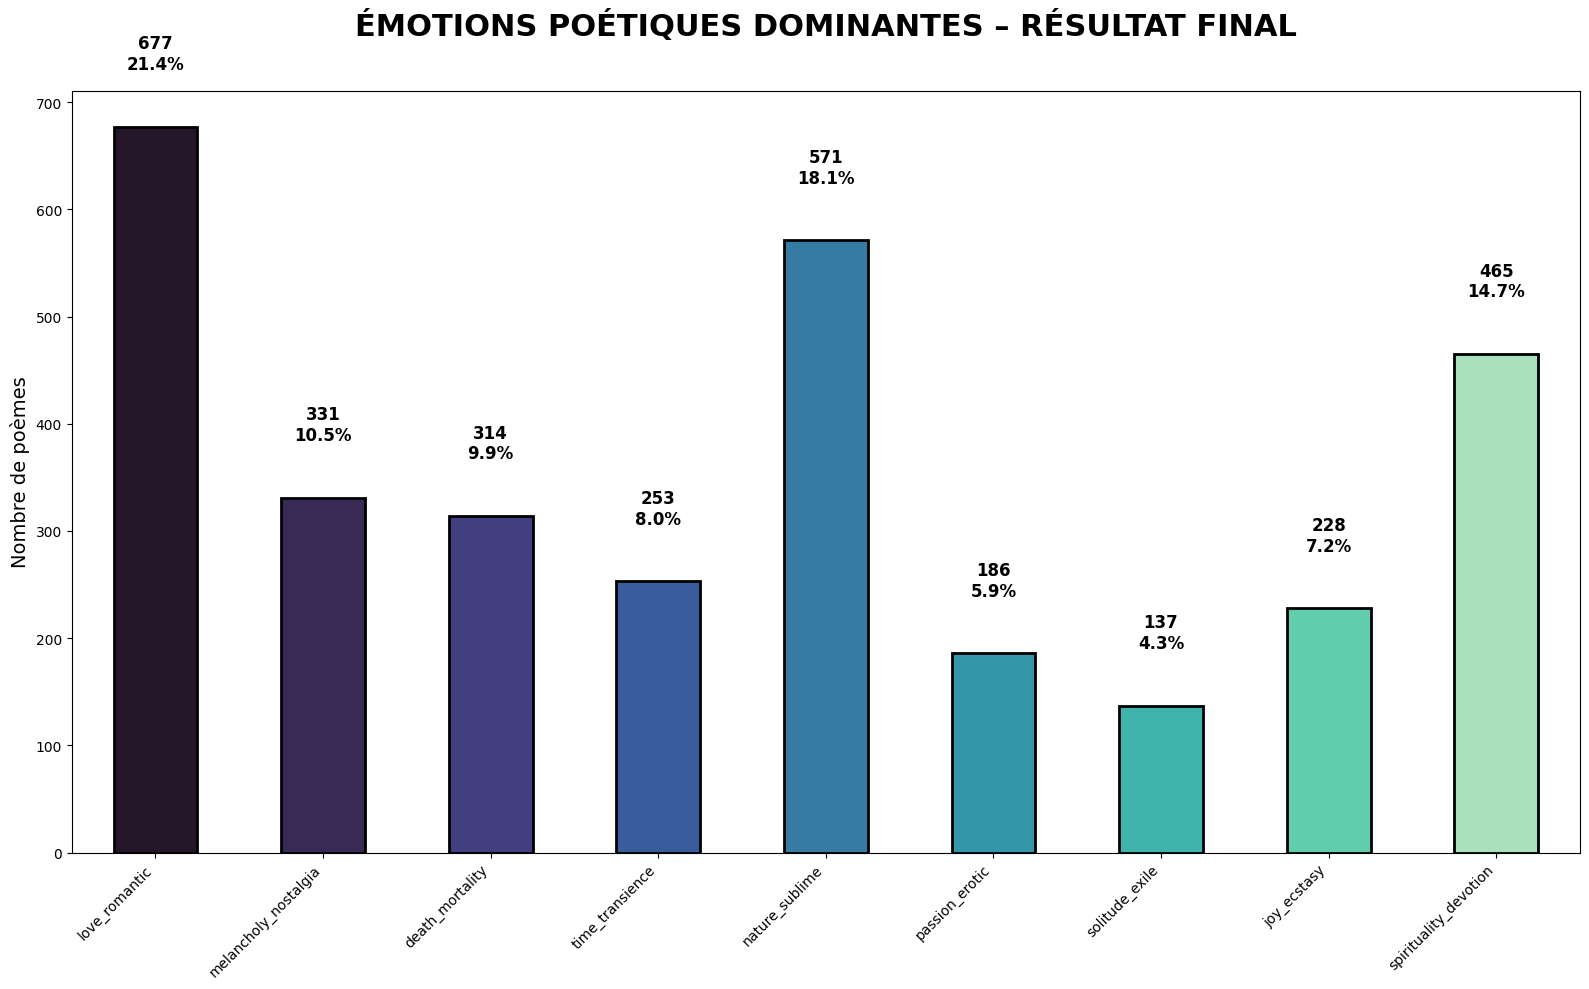


RÉPARTITION FINALE :
  Love Romantic                  →   677 poèmes ( 21.4%)
  Melancholy Nostalgia           →   331 poèmes ( 10.5%)
  Death Mortality                →   314 poèmes (  9.9%)
  Time Transience                →   253 poèmes (  8.0%)
  Nature Sublime                 →   571 poèmes ( 18.1%)
  Passion Erotic                 →   186 poèmes (  5.9%)
  Solitude Exile                 →   137 poèmes (  4.3%)
  Joy Ecstasy                    →   228 poèmes (  7.2%)
  Spirituality Devotion          →   465 poèmes ( 14.7%)


In [14]:
similarities = np.zeros((len(df), len(emotions)))
for i, emotion in enumerate(emotions):
    sim = cosine_similarity(X_poems, emotion_vectors[emotion]).flatten()
    similarities[:, i] = sim

df['predicted_emotion'] = np.array(emotions)[np.argmax(similarities, axis=1)]
df['confidence'] = np.max(similarities, axis=1)

# GRAPHIQUE FINAL
plt.figure(figsize=(16, 10))
counts = df['predicted_emotion'].value_counts().reindex(emotions, fill_value=0)
colors = sns.color_palette("mako", len(counts))

ax = counts.plot(kind='bar', color=colors, edgecolor='black', linewidth=2)
plt.title("ÉMOTIONS POÉTIQUES DOMINANTES – RÉSULTAT FINAL", 
          fontsize=22, fontweight='bold', pad=40)
plt.ylabel("Nombre de poèmes", fontsize=14)
plt.xticks(rotation=45, ha='right')

total = len(df)
for i, (emotion, count) in enumerate(counts.items()):
    pct = count/total*100
    ax.text(i, count + 50, f"{count}\n{pct:.1f}%", ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print("\nRÉPARTITION FINALE :")
for e, c in counts.items():
    print(f"  {e.replace('_', ' ').title():30} → {c:5} poèmes ({c/total*100:5.1f}%)")

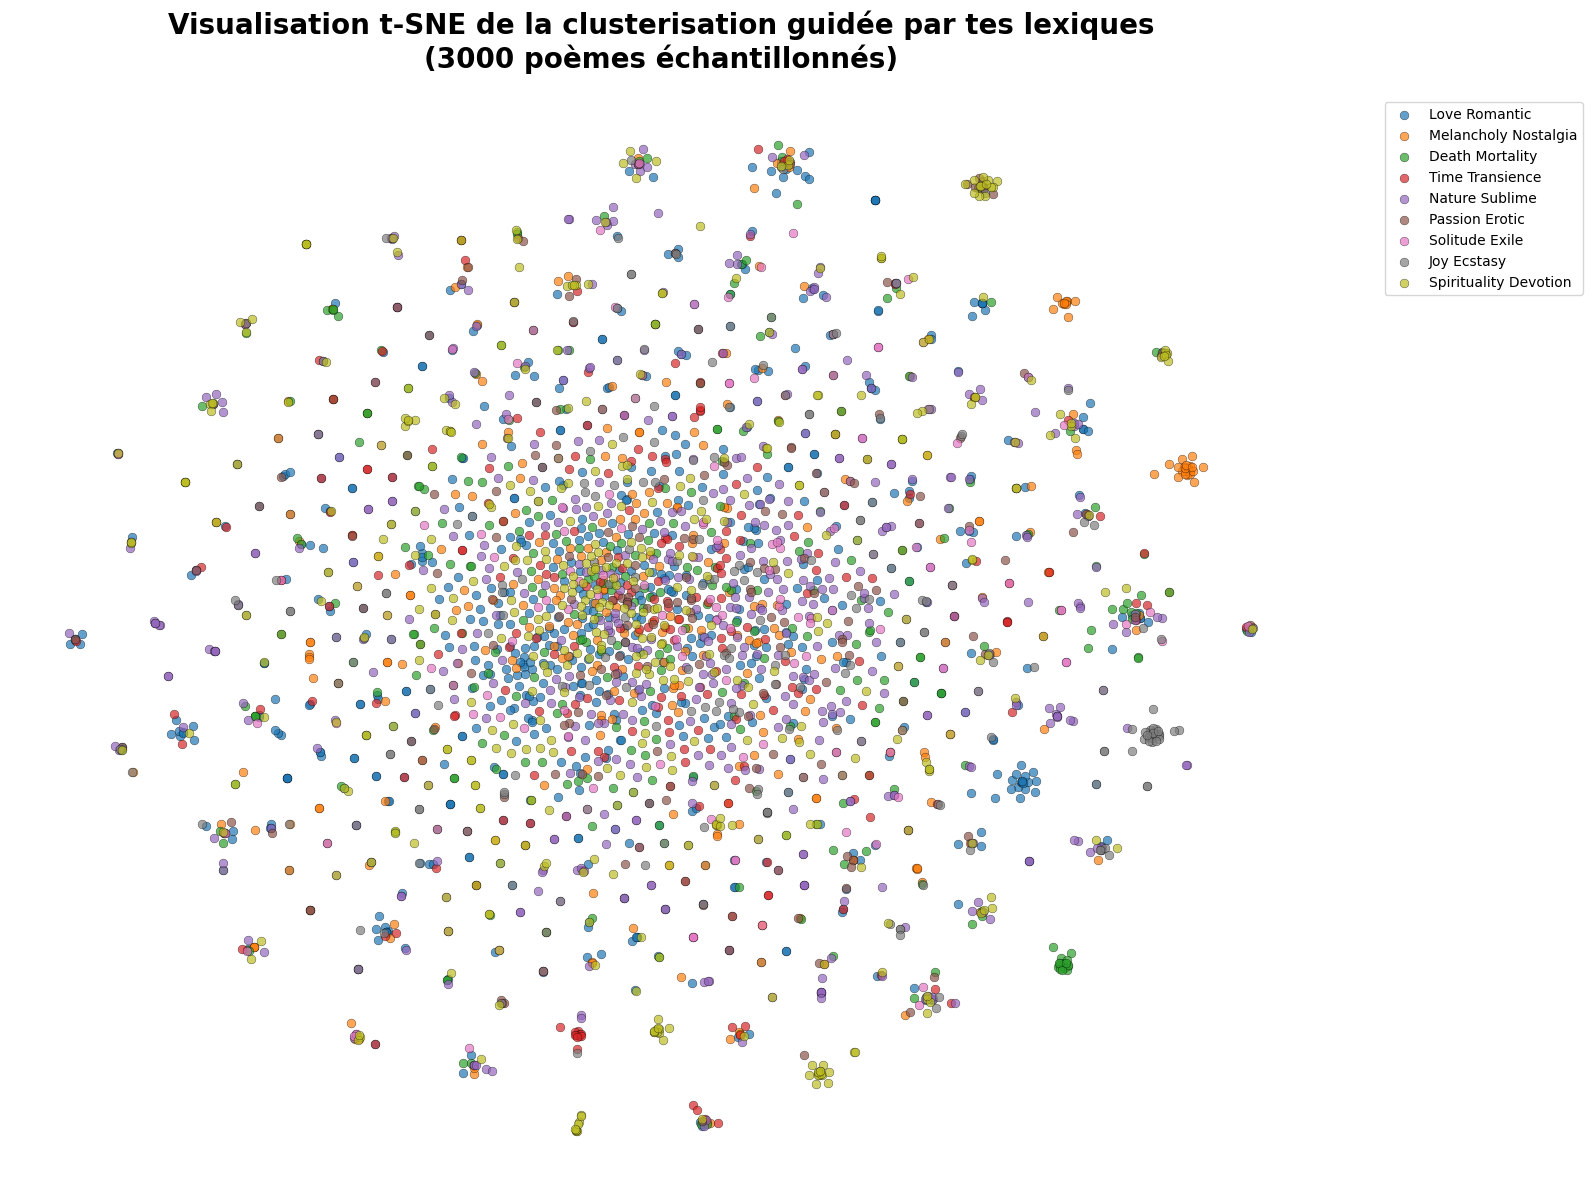

In [17]:
# VISUALISATION 2D DE LA CLUSTERISATION (t-SNE)
from sklearn.manifold import TSNE
import random

# Échantillon pour la vitesse
sample_idx = random.sample(range(len(df)), min(3000, len(df)))
X_sample = X_poems[sample_idx]
labels_sample = df['predicted_emotion'].iloc[sample_idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_sample.toarray())

plt.figure(figsize=(16,12))
colors = sns.color_palette("tab10", len(emotions))

for i, emotion in enumerate(emotions):
    idx = labels_sample == emotion
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                c=[colors[i]], label=emotion.replace('_', ' ').title(), 
                alpha=0.7, s=40, edgecolors='black', linewidth=0.3)

plt.title("Visualisation t-SNE de la clusterisation guidée par tes lexiques\n(3000 poèmes échantillonnés)", 
          fontsize=20, fontweight='bold', pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()

In [18]:
# À coller une fois pour toutes (après avoir exécuté tout le notebook)
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. On sauvegarde tout ce qu’il faut (exécute ça UNE SEULE FOIS)
pickle.dump({
    'vectorizer': vectorizer,           # le TF-IDF déjà fitté
    'emotion_vectors': emotion_vectors, # les 9 centroïdes pondérés
    'emotions': emotions
}, open("../models/poetic_mind_classifier.pkl", "wb"))

print("Modèle sauvegardé → ../models/poetic_mind_classifier.pkl")

FileNotFoundError: [Errno 2] No such file or directory: '../models/poetic_mind_classifier.pkl'